In [1]:
from pathlib import Path
import pywt

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import os
from glob import glob

In [2]:
DATASET_DIR = Path('data/HYPERVIEW2')

HSI_AIRBORNE_DIR = DATASET_DIR / 'train' / 'hsi_airborne'
HSI_SATELLITE_DIR = DATASET_DIR / 'train' / 'hsi_satellite'
MSI_SATELLITE_TRAIN_DIR = DATASET_DIR / 'train' / 'msi_satellite'
MSI_SATELLITE_TEST_DIR = DATASET_DIR / 'test' / 'msi_satellite'

GT_TRAIN_CSV_PATH = DATASET_DIR / 'train_gt.csv'
# %% Load the ground truth measurements
gt_train_df = pd.read_csv(GT_TRAIN_CSV_PATH)
ydf = gt_train_df.drop(['sample_index'], axis=1)
column_names = ['Fe', 'Zn', 'B', 'Cu', 'S', 'Mn']

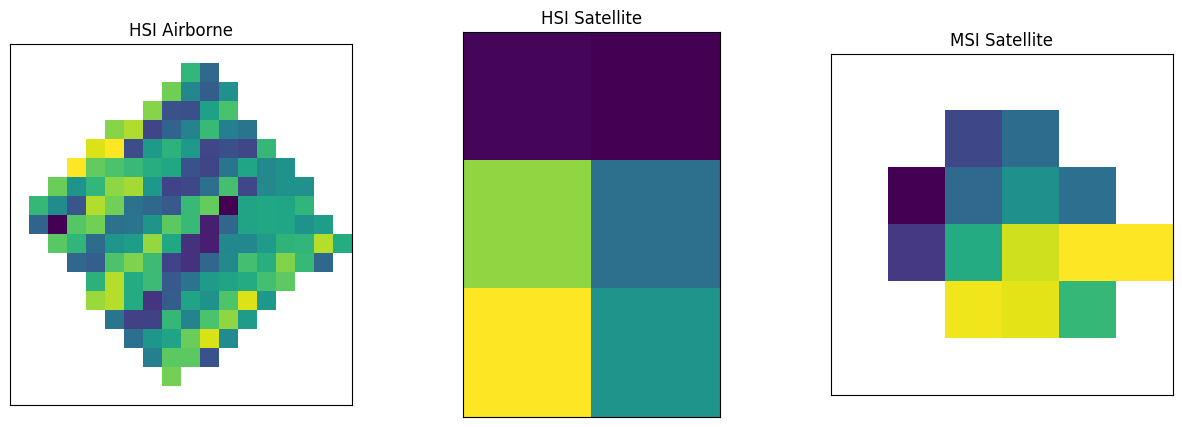

In [3]:
selected_index = 377
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
BAND_NUMBER = 7

# HSI airborne
with np.load(HSI_AIRBORNE_DIR / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)

    axs[0].imshow(arr[BAND_NUMBER, :, :])
    axs[0].set_title('HSI Airborne')
    axs[0].set_xticks([])
    axs[0].set_yticks([])


# HSI satellite
with np.load(HSI_SATELLITE_DIR / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)

    axs[1].imshow(arr[BAND_NUMBER, :, :].data)
    axs[1].set_title('HSI Satellite')
    axs[1].set_xticks([])
    axs[1].set_yticks([])

# MSI satellite
with np.load(MSI_SATELLITE_TRAIN_DIR / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)

    axs[2].imshow(arr[BAND_NUMBER, :, :])
    axs[2].set_title('MSI Satellite')
    axs[2].set_xticks([])
    axs[2].set_yticks([])


plt.show()

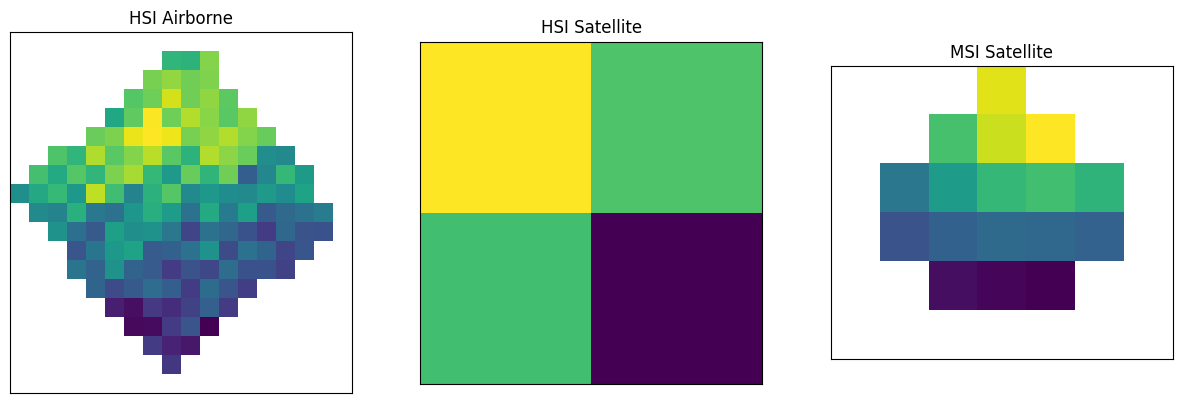

In [4]:
selected_index = 000
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
BAND_NUMBER = 7

# HSI airborne
with np.load(HSI_AIRBORNE_DIR / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)

    axs[0].imshow(arr[BAND_NUMBER, :, :])
    axs[0].set_title('HSI Airborne')
    axs[0].set_xticks([])
    axs[0].set_yticks([])


# HSI satellite
with np.load(HSI_SATELLITE_DIR / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)

    axs[1].imshow(arr[BAND_NUMBER, :, :].data)
    axs[1].set_title('HSI Satellite')
    axs[1].set_xticks([])
    axs[1].set_yticks([])

# MSI satellite
with np.load(MSI_SATELLITE_TRAIN_DIR / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)

    axs[2].imshow(arr[BAND_NUMBER, :, :])
    axs[2].set_title('MSI Satellite')
    axs[2].set_xticks([])
    axs[2].set_yticks([])


plt.show()

Text(0.5, 1.0, 'Spectral curve for a selected pixel')

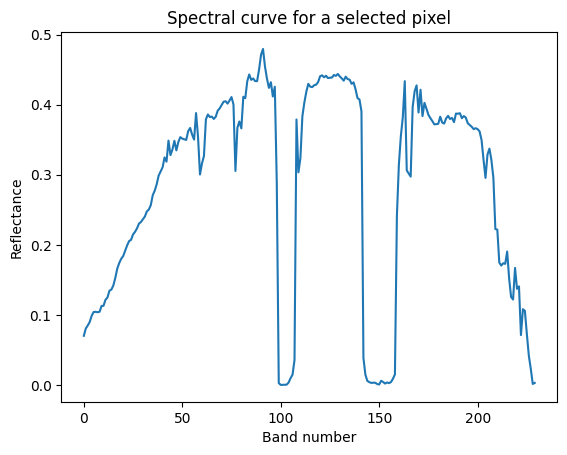

In [5]:
# %% [markdown]
"""
# Displaying spectral curve for a selected field
"""
selected_index = 377

with np.load(HSI_SATELLITE_DIR / f'{selected_index:04}.npz') as npz:
    arr = np.ma.MaskedArray(**npz)

pixel_0 = arr.data[:, 0, 0]

plt.plot(pixel_0)
plt.xlabel('Band number')
plt.ylabel('Reflectance')
plt.title('Spectral curve for a selected pixel')
